# Lesson 1 - Introduction to deep neural networks

> A first look at training deep neural networks to tag jets in proton-proton collisions.

## TODO

* Put dataset on the Hub with a loading script
* Figure out how to load `Dataset` objects in dataloaders
* Tidy up, add prose
* Add exercises
* Push model to Hub? => save for next lecture when we actually train from scratch
* Primer on N-subjettiness

## Learning objectives

* Understand what jet tagging is and how to frame it as a machine learning task
* Gain an introduction to the `fastai` library

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) by G. Kasieczka et al.
* N-subjet reference

## The data

For the first few lessons, we'll be analysing the _Top Quark Tagging_ dataset, which is a famous benchmark that's used to evaluate the performance of jet classification algorithms. The dataset can be obtained from either Zenodo or the Hugging Face Hub and is described as follows:

* 14 TeV, hadronic tops for signal, qcd diets background, Delphes ATLAS detector card with Pythia8
* No MPI/pile-up included
* Clustering of  particle-flow entries (produced by Delphes E-flow) into anti-kT 0.8 jets in the pT range [550,650] GeV
* All top jets are matched to a parton-level top within ∆R = 0.8, and to all top decay partons within 0.8
* Jets are required to have |eta| < 2
* The leading 200 jet constituent four-momenta are stored, with zero-padding for jets with fewer than 200
* Constituents are sorted by pT, with the highest pT one first
* A flag (1 for top, 0 for QCD) is kept for each jet. It is called is_signal_new

Framed as a supervised machine learning task, the goal is to train a model that can classify each jets as either a top quark signal or quark-gluon background.

## Import libraries

In [2]:
import torch.nn.functional as F
from datasets import load_dataset
from fastai.tabular.all import *
from scipy.interpolate import interp1d
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [3]:
import datasets

datasets.logging.set_verbosity_error()

## A first look at 🤗 Datasets

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download and process the datasets that we'll encounter in this course. 🤗 Datasets provides smart caching and allows you to process larger-than-RAM datasets by exploiting a technique called _memory-mapping_ that provides a mapping between RAM and filesystem storage.

To download the dataset, we can use the `load_dataset()` function:

In [6]:
dataset_id = "lewtun/top_quark_tagging"
top_quark_ds = load_dataset(dataset_id, name="raw", split="train", streaming=True)

In [8]:
# next(iter(top_quark_ds))

In [5]:
sample = list(top_quark_ds.take(5))
pd.DataFrame(sample)

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


As we can see, each row consists of 4-vectors $(E_i, p_{x_i}, p_{y_i}, p_{z_i})$ that correspond to the 200 particles that make up each jet. We can also see that each jet has been padded with zeros, since most won't have 200 particles. We also have an `is_signal_new` column that indicates whether the jet is a top quark signal (1) or QCD background (0).

## Jet representations

In any machine learning problem, the first step is to decide how to represent the data. For jet tagging, there have typically been several approaches:

* Use the raw point cloud data.
* Convert the data to images
* Use theory-inspired features like N-subjettiness.

## Representing jets with $N$-subjettiness

In [10]:
nsubjet_ds = load_dataset(dataset_id, name="nsubjettiness")
nsubjet_ds

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset top_quark_tagging downloaded and prepared to /home/lewis/.cache/huggingface/datasets/lewtun___top_quark_tagging/nsubjettiness/0.0.0/ab617914238dd6b4a8d883615322296bffb42618659b01559c43388c1b703343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 1211000
    })
    validation: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 404000
    })
})

In [11]:
nsubjet_ds["train"][0]

{'tau_1_0.5': 543.6339721679688,
 'tau_1_1': 0.16512173414230347,
 'tau_1_2': 0.032661281526088715,
 'tau_2_0.5': 0.0022617217618972063,
 'tau_2_1': 0.048829928040504456,
 'tau_2_2': 0.003710513934493065,
 'tau_3_0.5': 4.390962203615345e-05,
 'tau_3_1': 0.030994312837719917,
 'tau_3_2': 0.0016299881972372532,
 'tau_4_0.5': 1.1181864465470426e-05,
 'tau_4_1': 0.001115332474000752,
 'tau_4_2': 7.765891496092081e-06,
 'is_signal_new': 0}

In [12]:
train_df, test_df = nsubjet_ds["train"].to_pandas(), nsubjet_ds["test"].to_pandas()

In [13]:
train_df.head()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new
0,543.633972,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,0.000011,0.001115,0.000008,0
1,452.411865,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,0.000163,0.005454,0.000072,0
2,429.495270,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,0.001385,0.012678,0.000567,0
3,512.675415,0.102580,0.011369,0.000170,0.086306,0.007759,0.000071,0.068169,0.005386,0.000048,0.002376,0.000008,0
4,527.956848,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,0.004359,0.033249,0.003689,0


## Introducing fastai

### From data to DataLoaders

Now that we have downloaded our first dataset, it's time to wrangle it in a format that's suitable for training neural nets. In `fastai`, this means we need to create an object called `DataLoaders`.

To turn our dataset into a `DataLoaders` object we need to specify:

* What type of data we are dealing with (tabular, images, etc)
* How to get the examples
* How to label each example
* How to create the validation set

`fastai` provides a number of _factory methods_ that are convenient ways to quickly create a `DataLoaders` object. In our case, the data is in a _tabuluar_ format, so we can use the `TabularDataLoaders.from_df()` method to do this:

In [16]:
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    train_df, y_names="is_signal_new", bs=1000, y_block=CategoryBlock, splits=splits
)

Let's unpack this code a bit. We split our dataset into training and validaiton sets using the `RandomSplitter` class:

In [17]:
splits

((#968800) [56197,366255,1032564,106752,241088,829670,483972,868789,1142782,1033772...],
 (#242200) [429542,53893,1012620,698367,144414,346165,278364,990743,416382,260351...])

Explain `CategoryBlock` and `bs` and `y_names`

In [20]:
dls.show_batch()

,tau_4_0.5,tau_4_2,tau_3_1,tau_4_1,tau_2_0.5,tau_1_2,tau_3_0.5,tau_2_1,tau_3_2,tau_1_1,tau_2_2,tau_1_0.5,is_signal_new
0,0.002646,0.000652,0.168284,0.018302,0.089148,0.265248,0.029266,0.363591,0.033364,0.503636,0.143044,474.734161,1
1,0.005814,0.001478,0.219450,0.028015,0.043463,0.144448,0.012173,0.259690,0.055023,0.349679,0.080712,479.476501,1
2,0.000056,0.000022,0.044269,0.003159,0.005846,0.055352,0.002220,0.144247,0.003929,0.205768,0.031896,551.100342,0
3,0.007043,0.002760,0.219705,0.040629,0.105210,0.326334,0.042844,0.360403,0.060194,0.579568,0.165126,462.601837,1
4,0.007231,0.003477,0.165943,0.028515,0.021554,0.074485,0.008140,0.177030,0.040316,0.236287,0.045547,480.506561,0
5,0.001759,0.001229,0.171646,0.015074,0.061105,0.191326,0.010203,0.208858,0.031751,0.413293,0.056896,592.550659,1
6,0.000776,0.000593,0.117022,0.010112,0.053625,0.154415,0.015167,0.279056,0.018289,0.356082,0.089697,512.566528,1
7,0.002784,0.001207,0.140661,0.019237,0.018201,0.105460,0.009699,0.193670,0.035766,0.297140,0.066668,397.187164,0
8,0.000733,0.000428,0.090419,0.010936,4.803965,0.852682,4.744865,0.392383,0.013099,0.559244,0.789355,514.240356,0
9,0.004468,0.001086,0.153431,0.018334,0.049096,0.161745,0.029301,0.208116,0.045663,0.378922,0.092313,481.526703,0


### Create a Learner

In [22]:
learn = tabular_learner(dls, layers=[100, 100], metrics=[accuracy, RocAucBinary()])

In [23]:
learn.summary()

TabularModel (Input shape: 1000 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1000 x 12           
BatchNorm1d                               24         True      
____________________________________________________________________________
                     1000 x 100          
Linear                                    1200       True      
ReLU                                                           
BatchNorm1d                               200        True      
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               200        True      
____________________________________________________________________________
                     1000 x 2            
Linear                                    202        True      
____________________________________________________________________________

Total params: 11,826
Total tr

### Find a good learning rate

SuggestedLRs(valley=0.001737800776027143)

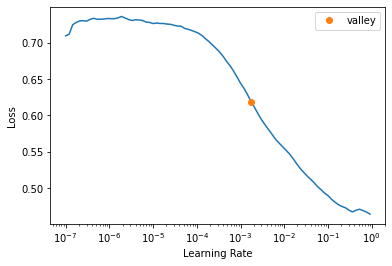

In [24]:
learn.lr_find()

### Train your model

In [25]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.256953,0.257858,0.889694,0.958573,00:08
1,0.241160,0.252786,0.890124,0.962595,00:08
2,0.234253,0.249138,0.891065,0.963505,00:08


In [26]:
learn.show_results()

,tau_1_2,tau_4_0.5,tau_1_1,tau_2_0.5,tau_3_2,tau_3_0.5,tau_2_1,tau_4_1,tau_1_0.5,tau_4_2,tau_2_2,tau_3_1,is_signal_new,is_signal_new_pred
0,0.568064,0.001906,0.547532,2.448554,0.025503,2.380191,0.311953,0.017975,497.404083,0.001171,0.449487,0.127556,1.0,1.0
1,0.240000,0.001116,0.483712,0.066756,0.031389,0.028697,0.314486,0.020007,516.652893,0.000713,0.122349,0.173533,1.0,1.0
2,0.222677,0.006287,0.447833,0.073248,0.069243,0.015953,0.331112,0.041239,419.849243,0.002643,0.115739,0.253424,1.0,1.0
3,0.156302,0.010616,0.382011,0.034030,0.061303,0.013037,0.253378,0.044847,460.127411,0.009875,0.074477,0.227193,1.0,1.0
4,0.182249,0.002375,0.391135,0.061537,0.035261,0.021044,0.288826,0.026862,432.314941,0.001465,0.101581,0.165579,1.0,1.0
5,0.177731,0.002577,0.396802,0.054459,0.029761,0.036373,0.334377,0.017925,511.252228,0.001663,0.129177,0.133739,1.0,1.0
6,0.089279,0.005871,0.263357,0.022551,0.038737,0.014446,0.236617,0.015613,528.263306,0.000723,0.073212,0.150028,1.0,0.0
7,0.372707,0.006909,0.590176,0.172101,0.056810,0.024048,0.311812,0.036499,467.772858,0.002317,0.121685,0.208302,1.0,1.0
8,0.027472,0.000350,0.157974,0.001132,0.010036,0.000452,0.108214,0.005730,513.965271,0.000091,0.013685,0.089757,0.0,0.0


### Evaluate your model

In [27]:
test_dl = learn.dls.test_dl(test_df)

In [28]:
preds = learn.get_preds(dl=test_dl)

In [29]:
rc = roc_curve(test_df["is_signal_new"], preds[0][:, 1])

In [30]:
len(rc)

3

In [31]:
rc[0].shape

(82684,)

In [32]:
rc[1].shape

(82684,)

In [33]:
rc[2].shape

(82684,)

(0.0, 1.0)

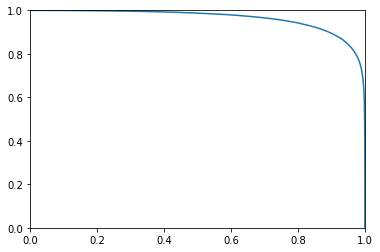

In [34]:
plt.plot(rc[1], 1 - rc[0], "-")
plt.xlim(0, 1)
plt.ylim(0, 1)

In [35]:
fpr_n, tpr_n, thresholds_n = roc_curve(
    y_true=test_df["is_signal_new"], y_score=preds[0][:, 1]
)

In [50]:
auc_n = auc(fpr_n, tpr_n)

background_eff_n = interp1d(tpr_n, fpr_n)
working_point_n = background_eff_n(0.3)

print(f"The area under the curve is {auc_n:0.3f}")
print(f"The backround rejection at signal efficieny 0.3 is {1/working_point_n:0.3f}")

The area under the curve is 0.963
The backround rejection at signal efficieny 0.3 is 261.547


In [55]:
1 / background_eff_n(1.0)

1.0

In [60]:
rejections = []
idxs = []

for i in range(0, 101):
    working_point_n = background_eff_n(i / 100.0)
    rejections.append(1 / working_point_n)
    idxs.append(i / 100.0)

/tmp/ipykernel_15495/2989435873.py:6: RuntimeWarning: divide by zero encountered in true_divide
  rejections.append(1/working_point_n)


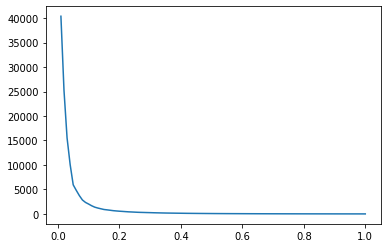

In [63]:
plt.plot(idxs, rejections, "-")
# plt.ylim(0,1000)